# Confirmation of MIMIC results with eICU database
- Ruoyi Jiang
- December 14, 2019
- Pre-liminary

In [6]:
library(tidyverse)
library(fasttime)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [7]:
PLOT_DIR <- "~/Google Drive/vasopressors/figures_v3"

In [8]:
### Plotting base_theme
base_theme <- function(){ theme_bw() + 
            theme(text=element_text(size=8)) +
            theme(plot.title=element_text(size=8)) +
            theme(plot.background=element_blank(),
                  panel.grid.major=element_blank(), 
                  panel.grid.minor=element_blank()) +
            theme(strip.background=element_blank(),
                  strip.text=element_text(size=7, face='bold')) +
            theme(axis.title=element_text(size=8, vjust=0.25),
                  axis.text.x=element_text(size=8, vjust=0.5, hjust=0.5),
                  axis.text.y=element_text(size=8)) +
            theme(legend.text=element_text(size=7),
                  legend.title=element_text(size=7),
                  legend.key.height=grid::unit(10, "points"), 
                  legend.key.width=grid::unit(10, "points"))}

In [9]:
EICU_DIR <- "/Users/ruoyijiang/Projects/Haimovich_Pressors/collection/eicu/alpha.physionet.org/files/eicu-crd/2.0"
#EICU_DIR <- "/Users/ruoyijiang/Projects/Haimovich_Pressors/collection/eicu_demo/alpha.physionet.org/files/eicu-crd-demo/2.0"

eicu_infusions <- read_csv(file.path(EICU_DIR, "medication.csv.gz"))

Parsed with column specification:
cols(
  medicationid = col_double(),
  patientunitstayid = col_double(),
  drugorderoffset = col_double(),
  drugstartoffset = col_double(),
  drugivadmixture = col_character(),
  drugordercancelled = col_character(),
  drugname = col_character(),
  drughiclseqno = col_double(),
  dosage = col_character(),
  routeadmin = col_character(),
  frequency = col_character(),
  loadingdose = col_logical(),
  prn = col_character(),
  drugstopoffset = col_double(),
  gtc = col_double()
)
Warning message:
“254 parsing failures.
    row         col           expected actual                                                                                                                     file
1843066 loadingdose 1/0/T/F/TRUE/FALSE   0 mg '/Users/ruoyijiang/Projects/Haimovich_Pressors/collection/eicu/alpha.physionet.org/files/eicu-crd/2.0/medication.csv.gz'
1848106 loadingdose 1/0/T/F/TRUE/FALSE   0 mg '/Users/ruoyijiang/Projects/Haimovich_Pressors/collection/eicu/

In [10]:
input_df <- eicu_infusions %>%
    filter(routeadmin == 'CENTRAL IV') %>%
    mutate(drugname = tolower(drugname)) %>%
    filter(grepl("norepinephrine", drugname) | 
           grepl("epinephrine", drugname) |
           grepl("phenylephrine", drugname) |
           grepl("vasopressin", drugname) |
           grepl("dobutamine", drugname) |
           grepl("dopamine", drugname)
           )  %>%
    mutate(duration_minutes = drugstopoffset - drugstartoffset) %>%
    filter(duration_minutes > 0) %>%
    group_by(patientunitstayid) %>%
    arrange(drugstartoffset) %>%
    mutate(intervening_minutes = (drugstopoffset - lag(drugstopoffset)) - duration_minutes) %>%
    rowwise() %>%
    mutate(increasing = if(intervening_minutes < (24*60) | is.na(intervening_minutes)){0}else(1)) %>%
    ungroup() %>%
    group_by(patientunitstayid) %>%
    mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_minutes, -increasing)

In [11]:
output_df <- input_df %>%
    group_by(patientunitstayid, continuous_course) %>%
    mutate(MORETHAN24HOURS = sum(duration_minutes) > 24*60, 
           STATUS = if(sum(duration_minutes) > 24*60){"MORETHAN24HOURS"}
           else if(sum(duration_minutes) <= 24*60 & sum(duration_minutes) > 6*60){"LESSTHAN24HOURS"}
           else if(sum(duration_minutes) <= 6*60){"LESSTHAN6HOURS"}
               ) %>%
    summarize(MORETHAN24HOURS = unique(MORETHAN24HOURS)[1],
                duration_minutes = sum(duration_minutes),
              drugname = paste(unique(drugname), collapse=",")) %>%
    mutate(RESPONSE = grepl(",", drugname) | MORETHAN24HOURS) %>%
    mutate(DIFF = duration_minutes/60)

In [12]:
dim(output_df)

[1] 1443    7

In [9]:
head(output_df)

patientunitstayid,continuous_course,MORETHAN24HOURS,duration_minutes,drugname,RESPONSE,DIFF
<dbl>,<dbl>,<lgl>,<dbl>,<chr>,<lgl>,<dbl>
1074367,0,TRUE,6151,norepinephrine bitartrate 1 mg/ml ij soln,TRUE,102.51667
1074378,0,TRUE,3388,norepinephrine bitartrate 1 mg/ml ij soln,TRUE,56.46667
1074392,0,TRUE,4068,"norepinephrine bitartrate 1 mg/ml ij soln,phenylephrine hcl 10 mg/ml ij soln",TRUE,67.80000
1074493,0,TRUE,2072,phenylephrine hcl 10 mg/ml ij soln,TRUE,34.53333
1074658,0,TRUE,1576,norepinephrine bitartrate 1 mg/ml iv soln,TRUE,26.26667
1074691,0,TRUE,1943,norepinephrine bitartrate 1 mg/ml ij soln,TRUE,32.38333


Warning message:
“Removed 170 rows containing non-finite values (stat_density).”

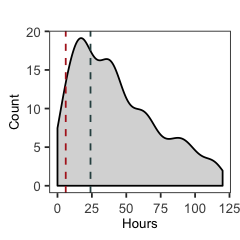

In [20]:
options(repr.plot.width=2, repr.plot.height=2)

# plot duration between last pressor course ended and CVC was started
p <- output_df %>%
    ggplot(aes(x=DIFF)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..count..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Count")+
        xlim(0, 120) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F")
plot(p)

In [22]:
pdf(file.path(PLOT_DIR, "eicu_histo_durations.pdf"), 2, 2)
plot(p)
dev.off()

Warning message:
“Removed 170 rows containing non-finite values (stat_density).”

pdf 
  2

In [23]:
output_df %>%
    group_by(RESPONSE) %>%
    summarize(COUNT = n()) %>% ungroup() %>%
    mutate(COUNT = COUNT/sum(COUNT))

RESPONSE,COUNT
<lgl>,<dbl>
FALSE,0.2820513
TRUE,0.7179487
